In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
import pickle

# Bank Marketing Campaign

# Bussiness Understanding
**Context**

Berikut adalah data dari hasil kampanye pemasaran bank yang dilakukan melalui panggilan telepon langsung untuk menaruh deposit berjangka. Untuk klien yang setuju untuk menaruh deposit, variabel target akan diisi dengan 'yes', jika tidak 'no'

Target: 
* 0 : Tidak menaruh deposit 
* 1 : Menaruh deposit



**Problem Statement**

Proses kampanye penawaran deposit memakan waktu dan biaya, jika bank menargetkan semua nasabah tanpa melakukan penyaringan terlebih dahulu, maka akan ada pemborosan dari segi waktu dan biaya. Bank ingin meningkatkan efisiensi proses kampanye dengan menargetkan ke calon nasabah yang memiliki potensi untuk menaruh deposit.


**Goals**

Berdasarkan permasalahan tersebut, bank ingin memiliki kemampuan untuk memprediksi kemungkinan kandidat nasabah untuk mau menaruh deposit atau tidak, sehingga dapat menargetkan kampanye pada kandidat yang memiliki potensial untuk menaruh deposit.

Dan juga, perusahaan ingin mengetahui kriteria apa saja yang berpengaruh pada kandidat nasabah yang sudah menaruh deposit dan yang tidak menaruh deposit. 


**Analytic Approach**

Yang akan lakukan adalah menganalisis data untuk menemukan pola yang membedakan kandidat nasabah yang akan menaruh deposit atau tidak.

Kemudian, dilanjutkan dengan membangun model klasifikasi yang akan membantu bank untuk dapat memprediksi probabilitas seorang kandidat nasabah akan/ingin menaruh deposit atau tidak.


**Metric Evaluation**

Type 1 error : False Positive  
Konsekuensi: membuang waktu dan biaya kampanye untuk nasabah yang tidak berpotensial menaruh deposit

Type 2 error : False Negative  
Konsekuensi: kehilangan kandidat nasabah potensial

Berdasarkan konsekuensinya, maka sebisa mungkin akan dibuat model yang dapat mengurangi cost kampanye dari bank, tetapi tanpa membuat menjadi kurangnya kandidat nasabah potensial yang dicari oleh bank. Jadi kita ingin sebanyak mungkin prediksi kelas positif yang benar, dengan sesedikit mungkin prediksi false positive. Jadi nanti metric utama yang akan kita gunakan adalah F1 Score.


**Data Understanding**

Note : 
- Dataset tidak seimbang
- Sebagian besar fitur memiliki jenis kategorikal (Nominal dan Ordinal), beberapa dengan kardinalitas tinggi
- Setiap baris data merepresentasikan informasi kandidat nasabah yang sudah pernah menaruh deposit dimasa lalu

### Attribute Information

| Attribute | Data Type | Description |
| --- | --- | --- |
| age | Numeric | umur nasabah |
| job | Text | pekerjaan nasabah |
| balance | Float | jumlah saldo tahunan |
| housing | Text | memiliki cicilan rumah |
| loan | Text | memiliki hutang |
| contact | Text | jenis alat komunikasi |
| month | Text | bulan terakhir dihubungi dalam 1 tahun |
| campaign | Numeric | jumlah kontak yang dilakukan selama kampanye |
| pdays | Numeric | jumlah hari setelah kandidat nasabah dihubungi |
| poutcome | Text | hasil dari kampanye sebelumnya |
| deposit | Text | kandidat nasabah menaruh deposit berjangka |

## DATA CLEANING

In [188]:
df = pd.read_csv('bank_marketing.csv')
df

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no


In [189]:
# melihat unique data pada masing-masing kolom
def Check (x):
    Type = []
    Count = []
    Sample = []
    MissVal = []
    for i in x.columns:
        Sample.append(x[i].unique()[:5])
        Count.append(x[i].nunique())
        Type.append(x[i].dtype)
        MissVal.append(x[i].isna().sum())
    check = pd.DataFrame({
        'Columns' : df.columns,
        'Dtype' : Type,
        'Nunique' : Count,
        'Missing Value' : MissVal,
        'Unique' : Sample
    })
    return check

In [190]:
Check(df)

,Columns,Dtype,Nunique,Missing Value,Unique
0,age,int64,75,0,"[55, 39, 51, 38, 36]"
1,job,object,12,0,"[admin., self-employed, services, housemaid, t..."
2,balance,int64,3153,0,"[1662, -3058, 3025, -87, 205]"
3,housing,object,2,0,"[no, yes]"
4,loan,object,2,0,"[no, yes]"
5,contact,object,3,0,"[cellular, telephone, unknown]"
6,month,object,12,0,"[jun, apr, may, nov, jan]"
7,campaign,int64,32,0,"[2, 3, 1, 4, 5]"
8,pdays,int64,422,0,"[-1, 352, 21, 91, 186]"
9,poutcome,object,4,0,"[unknown, other, failure, success]"


In [191]:
# mengecek data kosong
df.isnull().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

In [192]:
# mengecek data kosong
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

In [193]:
# mengecek data duplikat
df[df.duplicated()]

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
2944,40,blue-collar,0,yes,no,unknown,may,2,-1,unknown,no
4368,60,management,0,no,no,cellular,aug,3,-1,unknown,yes
4874,41,management,0,no,no,cellular,aug,2,-1,unknown,no
5326,44,blue-collar,0,yes,no,cellular,jul,1,-1,unknown,no
5609,39,technician,0,yes,no,unknown,may,1,-1,unknown,no
5681,38,technician,0,no,no,cellular,aug,2,-1,unknown,no
5905,34,management,0,no,no,cellular,aug,2,-1,unknown,no
7077,30,blue-collar,239,yes,no,unknown,may,1,-1,unknown,yes


data duplikat diabaikan karena kolom yang ada pada data merupakan kolom yang memungkinkan untuk seseorang memiliki data yang sama (tidak ada data NIK/nama) dan dianggap sesuai dengan kondisi aktual

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [195]:
df.describe()

,age,balance,campaign,pdays
count,7813.000000,7813.000000,7813.000000,7813.000000
mean,41.257264,1512.448611,2.519775,51.408550
std,11.919710,3089.291831,2.727001,108.072739
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,127.000000,1.000000,-1.000000
50%,39.000000,549.000000,2.000000,-1.000000
75%,49.000000,1684.000000,3.000000,40.000000
max,95.000000,66653.000000,63.000000,854.000000


Terdapat data outliers pada semua kolom numerikal, tetapi akan diabaikan dan tetap digunakan untuk pembuatan model karena dianggap sesuai dengan kondisi aktual

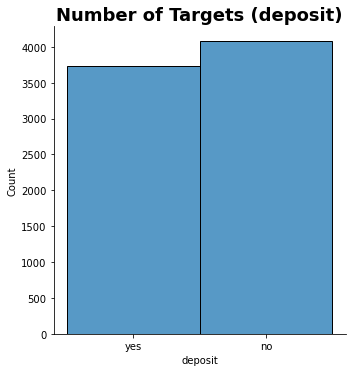

In [196]:
sns.displot(data = df, x = 'deposit')
plt.title("Number of Targets (deposit)", size=18, weight='bold')
plt.show()

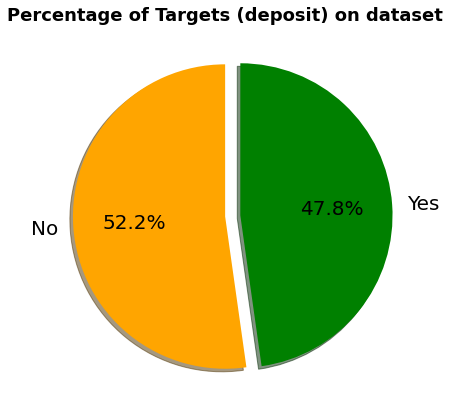

In [197]:
plt.figure(figsize=(7,7))
plt.title("Percentage of Targets (deposit) on dataset", size=18, weight='bold')
plt.pie(df['deposit'].value_counts(), explode=(0,0.1), labels=['No', 'Yes'], colors=["orange","green"], autopct='%1.1f%%', shadow=True, 
        startangle=90, textprops={"fontsize":20})

plt.show()

perbandingan depositor antara 'Yes' dan 'No' relatif seimbang, sehingga tidak diperlukan treatment data imbalance.

## DATA PREPARATION

In [198]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki. Yang akan kita lakukan adalah :
1. Merubah fitur/kolom `job` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
2. Merubah fitur/kolom `housing` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
3. Merubah fitur/kolom `loan` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4. Merubah fitur/kolom `contact` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
5. Merubah fitur/kolom `month` menggunakan Ordinal Encoding, karena fitur ini memiliki urutan
6. Merubah fitur/kolom `poutcome` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.

In [199]:
ordinal_mapping = [
    {'col':'month',
    'mapping':{
        'jan'       :    0,
        'feb'       :    1, 
        'mar'       :    2, 
        'apr'       :    3, 
        'may'       :    4, 
        'jun'       :    5,
        'jul'       :    6,
        'aug'       :    7,
        'sep'       :    8, 
        'oct'       :    9, 
        'nov'       :    10, 
        'dec'       :    11,
    }}
]

In [200]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop = 'first'), ['housing', 'loan', 'contact', 'poutcome', 'job']),
    ('ordinal', ce.OrdinalEncoder(mapping = ordinal_mapping), ['month'])
], remainder = 'passthrough')

In [201]:
x = df.drop(columns=['deposit'])
y = np.where(df['deposit'] == 'yes', 1 ,0)

In [202]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state=2020)

In [203]:
x_train_preprocessed = transformer.fit_transform(x_train)
x_train_preprocessed

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  6.7480e+03,
         2.0000e+00, -1.0000e+00],
       [ 1.0000e+00,  1.0000e+00,  1.0000e+00, ...,  0.0000e+00,
         1.3000e+01, -1.0000e+00],
       [ 1.0000e+00,  1.0000e+00,  0.0000e+00, ...,  8.9200e+02,
         1.0000e+00, -1.0000e+00],
       ...,
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  4.9000e+02,
         1.0000e+00, -1.0000e+00],
       [ 1.0000e+00,  0.0000e+00,  0.0000e+00, ...,  3.4690e+03,
         1.0000e+00, -1.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  5.2587e+04,
         1.0000e+00, -1.0000e+00]])

In [204]:
test = pd.DataFrame(x_train_preprocessed, columns = transformer.get_feature_names())
test

C:\Users\Krisna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,onehot__x0_yes,onehot__x1_yes,onehot__x2_telephone,onehot__x2_unknown,onehot__x3_other,onehot__x3_success,onehot__x3_unknown,onehot__x4_blue-collar,onehot__x4_entrepreneur,onehot__x4_housemaid,...,onehot__x4_services,onehot__x4_student,onehot__x4_technician,onehot__x4_unemployed,onehot__x4_unknown,ordinal__month,age,balance,campaign,pdays
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,7.0,33.0,6748.0,2.0,-1.0
1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,61.0,0.0,13.0,-1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,50.0,892.0,1.0,-1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,6.0,41.0,201.0,8.0,-1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,34.0,575.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,254.0,1.0,188.0
6246,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,60.0,14.0,4.0,178.0
6247,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,25.0,490.0,1.0,-1.0
6248,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,52.0,3469.0,1.0,-1.0


## MODEL SELECTION

In [205]:
knn = KNeighborsClassifier(n_neighbors = 3)
logreg = LogisticRegression(max_iter = 200, random_state = 2020)
rf = RandomForestClassifier(max_depth = 3, random_state = 2020)
dt = DecisionTreeClassifier(max_depth = 3,random_state = 2020)
xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 3, random_state = 2020)

In [206]:
models = [knn, logreg, rf, dt, xgb]
score=[]
rata=[]
std=[]

for i in models:
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', i)])
    model_cv = cross_val_score(estimator, x_train, y_train, cv = skfold, scoring = 'f1')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

C:\Users\Krisna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Krisna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [207]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'], 'f1 score' : rata, 'std dev' : std}).set_index('model').sort_values('f1 score', ascending = False)

,f1 score,std dev
model,,
XGBoost,0.679891,0.015517
KNN,0.656540,0.012651
Random Forest,0.649476,0.012688
Decision Tree,0.600055,0.017083
Logistic Regression,0.544085,0.015967


## MODEL BENCHMARKING: TEST DATA

In [208]:
models = {
    'xgb' : XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 3, random_state = 2020),
    'knn' : KNeighborsClassifier(n_neighbors = 3)
}

xgb
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       816
           1       0.74      0.63      0.68       747

    accuracy                           0.72      1563
   macro avg       0.72      0.71      0.71      1563
weighted avg       0.72      0.72      0.71      1563



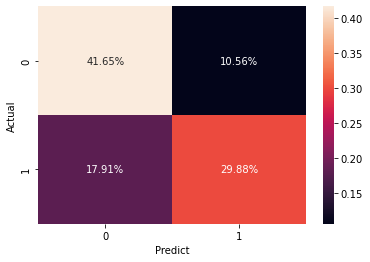

knn
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       816
           1       0.57      0.54      0.55       747

    accuracy                           0.58      1563
   macro avg       0.58      0.58      0.58      1563
weighted avg       0.58      0.58      0.58      1563



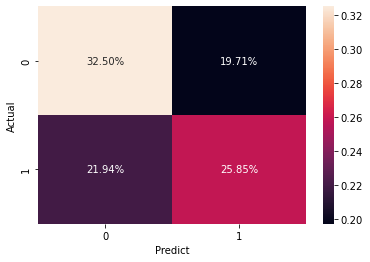

In [209]:
for i, j in models.items():
    estimator = Pipeline([
    ('processing', transformer),
    ('model', j)
    ])
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    print(i)
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred)/np.sum(confusion_matrix(y_test, y_pred)), annot = True, fmt = '.2%')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.show()

Setelah melihat hasil benchmarking dari data test, score tertinggi didapatkan oleh model XGBoost

## TUNING

In [210]:
# model yang dipilih adalah XGBoost karena memiliki F1 Score paling tinggi
xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 3, random_state = 2020)

In [211]:
estimator=Pipeline([
    ('processing', transformer),
    ('model', xgb)
])

In [212]:
hyperparam_space = [
    {
    'model__learning_rate':[0.1],
    'model__n_estimators':[200],
    'model__max_depth':[3,4,5, 6, 7]
    },
    {
    'model__learning_rate':[0.01],
    'model__n_estimators':[500],
    'model__max_depth':[3,4,5, 6, 7]
    },
]

In [213]:
skfold = StratifiedKFold(n_splits = 5)
grid = GridSearchCV(estimator,
                 param_grid = hyperparam_space,
                 cv = skfold,
                 scoring = 'f1',
                 n_jobs = -1)

In [214]:
grid.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('processing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'poutcome',
                                                                          'job']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'month',
                                                                                                  'mapping': {'apr': 3,
                                                                                                              'aug': 7,
                                                                                                              'dec': 11,
                                                                                                              'feb': 1...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=200,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=2020, ...))]),
             n_jobs=-1,
             param_grid=[{'model__learning_rate': [0.1],
                          'model__max_depth': [3, 4, 5, 6, 7],
                          'model__n_estimators': [200]},
                         {'model__learning_rate': [0.01],
                          'model__max_depth': [3, 4, 5, 6, 7],
                          'model__n_estimators': [500]}],
             scoring='f1')

In [215]:
y_pred=grid.best_estimator_

In [216]:
print(classification_report(y_test, y_pred.predict(x_test)))


              precision    recall  f1-score   support

           0       0.70      0.81      0.75       816
           1       0.75      0.63      0.68       747

    accuracy                           0.72      1563
   macro avg       0.72      0.72      0.71      1563
weighted avg       0.72      0.72      0.72      1563



In [217]:
grid.best_params_, grid.best_score_

({'model__learning_rate': 0.1,
  'model__max_depth': 5,
  'model__n_estimators': 200},
 0.6809573716616251)

In [218]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

In [219]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       816
           1       0.75      0.63      0.68       747

    accuracy                           0.72      1563
   macro avg       0.72      0.72      0.71      1563
weighted avg       0.72      0.72      0.72      1563



## FEATURE IMPORTANCES

In [220]:
features = list(best_model[0].transformers_[0][1].get_feature_names_out()) + (best_model[0].transformers_[1][1].get_feature_names()) + list(x.columns[best_model[0].transformers_[2][2]])

In [221]:
pd.DataFrame({'imp' : best_model[1].feature_importances_}, index = features).sort_values('imp', ascending = False).head()

,imp
poutcome_success,0.440111
contact_unknown,0.175996
housing_yes,0.046298
loan_yes,0.033366
month,0.031408


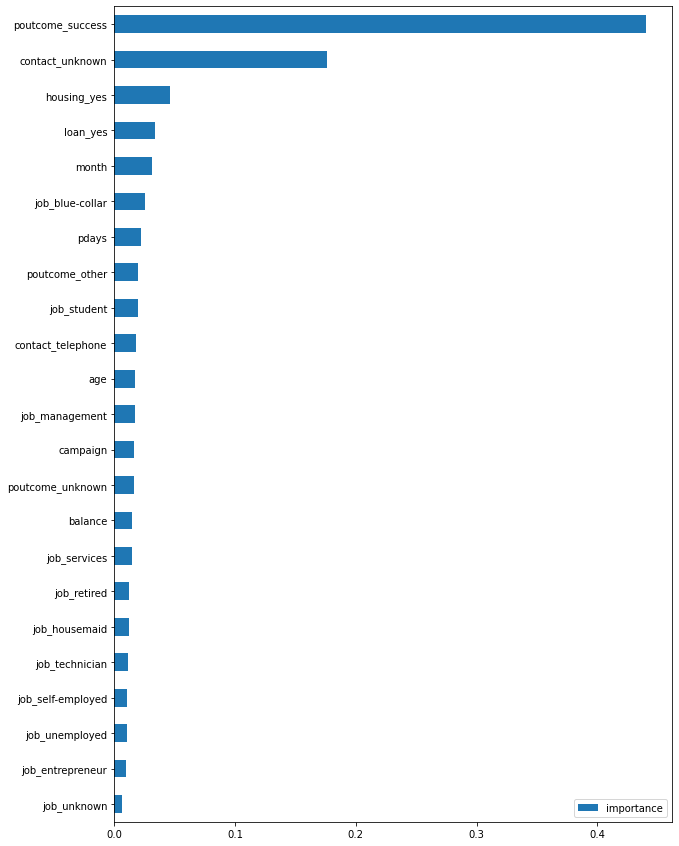

In [222]:
#visualisasi
pd.DataFrame({'importance' : best_model[1].feature_importances_}, index = features).sort_values('importance', ascending = True).plot(kind = 'barh', figsize = (10, 15))
plt.show()

Terlihat pada model kita bahwa fitur/kolom poutcome_success adalah yang paling penting, diikuti dengan contact_unknown, dan seterusnya.

## CONCLUSION & RECOMMENDATION

In [223]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       816
           1       0.75      0.63      0.68       747

    accuracy                           0.72      1563
   macro avg       0.72      0.72      0.71      1563
weighted avg       0.72      0.72      0.72      1563



C:\Users\Krisna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


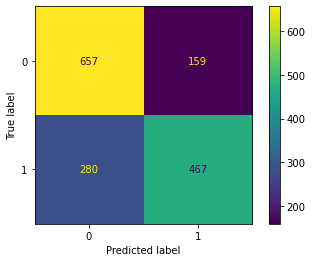

In [224]:
plot_confusion_matrix(best_model, x_test, y_test)

**Conclusion:**

Berdasarkan hasil classification report model, dapat disimpulkan bahwa bila seandainya menggunakan model ini untuk memfilter/menyaring list kandidat nasabah, maka model ini dapat mengurangi 81% kandidat nasabah tidak potensial untuk tidak di approach melalui kampanye, dan model dapat memprediksi dengan benar 63% kandidat nasabah yang tertarik. (berdasarkan recall)

Model memiliki ketepatan prediksi kandidat nasabah potensial sebesar 75% (berdasarkan precision). Maka masih akan ada kandidat nasabah yang sebenarnya tidak tertarik tetapi diprediksi sebagai kandidat potensial sekitar 19% dari keseluruhan kandidat yang tidak potensial (berdasarkan recall).

Tanpa model, perusahaan akan melakukan kampanye terhadap 1563 kandidat nasabah yang mana tidak semuanya adalah kandidat nasabah potensial untuk menaruh deposit. Sedangkan dengan model, perusahaan dapat mengerucutkan target kampanye menjadi hanya 629 kandidat nasabah potensial saja, yang mana ini akan meningkatkan efisiensi bagi bank baik dari segi finansial maupun waktu.

maka dari itu, kesimpulannya adalah penggunaan model dapat menjawab bussiness problem bank.

**Recommendation:**

Beberapa poin yang bisa dilakukan untuk membuat model menjadi lebih baik adalah:
* menambah fitur yang memiliki pengaruh kuat terhadap target, misal: status perkawinan, pendapatan, dll
* melakukan improvisasi pada model seperti melakukan hyperparameter tuning kembali, atau membuat model dengan algoritma yang lain

## SAVE MODEL

In [225]:
best_model = grid.best_estimator_
bank_model = best_model.fit(x, y)
pickle.dump(bank_model, open('xgb_model.sav', 'wb'))